# Image Data
Ved billeder har man 3 dimensioner (medmindre man har dybde, så har man mere) 
- Image height
- Image width
- Color channels



# Convolutional Neural Network
Forskellen mellem dense neural networks og CNNs, er at DNN lærer ting på globalt plan, så hvis et billede lige pludselig bliver flipped, vil det måske ikke så godt kunne genkendes. Den er ikke så god til at se på ting som ikke ligner 100% det man har trænet på.

Med CNN kan man lære ting lokalt, hvilket gør det rigtig smart når ting bliver vist i en anden position eller orientering (godt til fly)

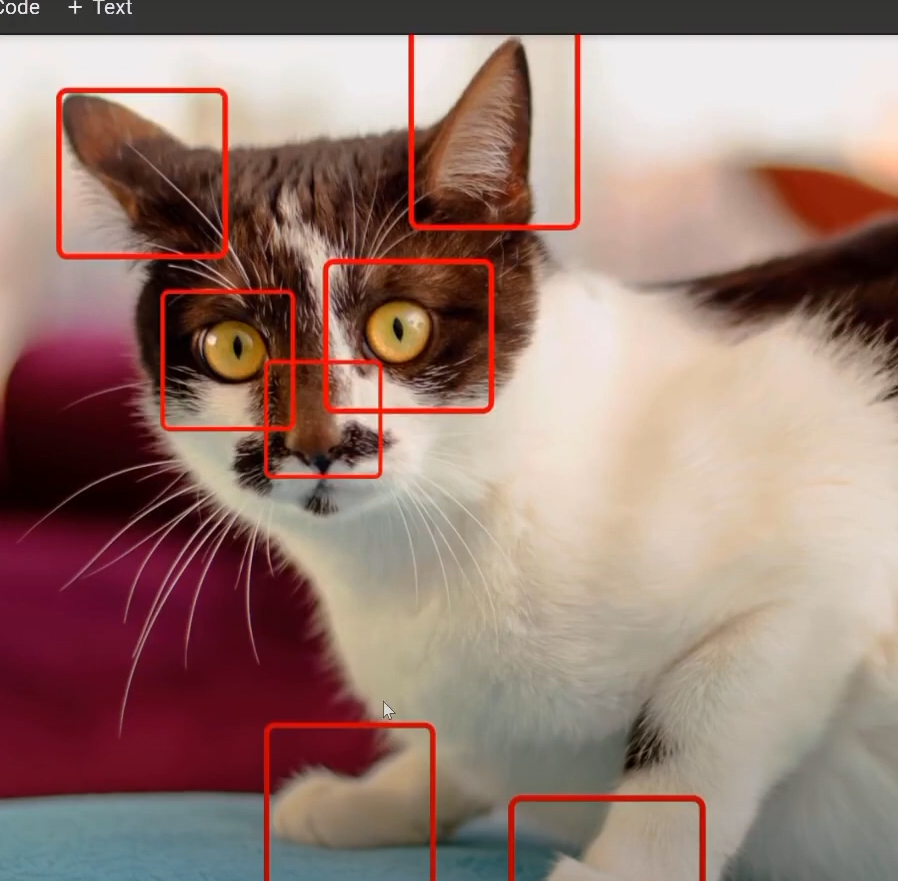



### Convolutional Layer:
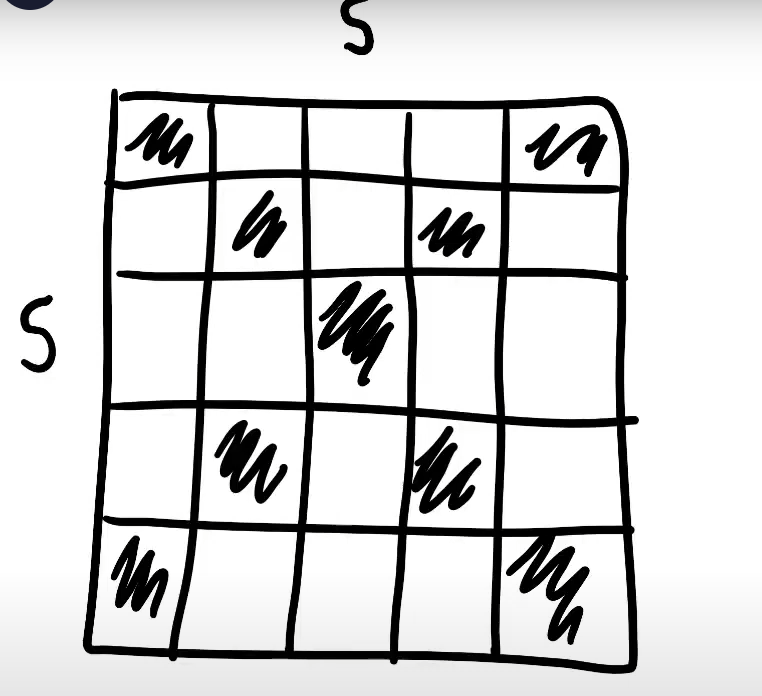

Outputtet af sådan et lag her vil være et feature map, som fortæller os om der er filters i billedet. 

Properties:
- Input size
- Filters - kan være forskellige ting, men man har typisk x32, x64 eller den slags filtre. Det er filtre man træner. 
- Sample Filters

Man har så en filter size (kernel), som man looper over billedet, og ser på hvor meget det ligner dit filter, og det gør du for alle i guess.
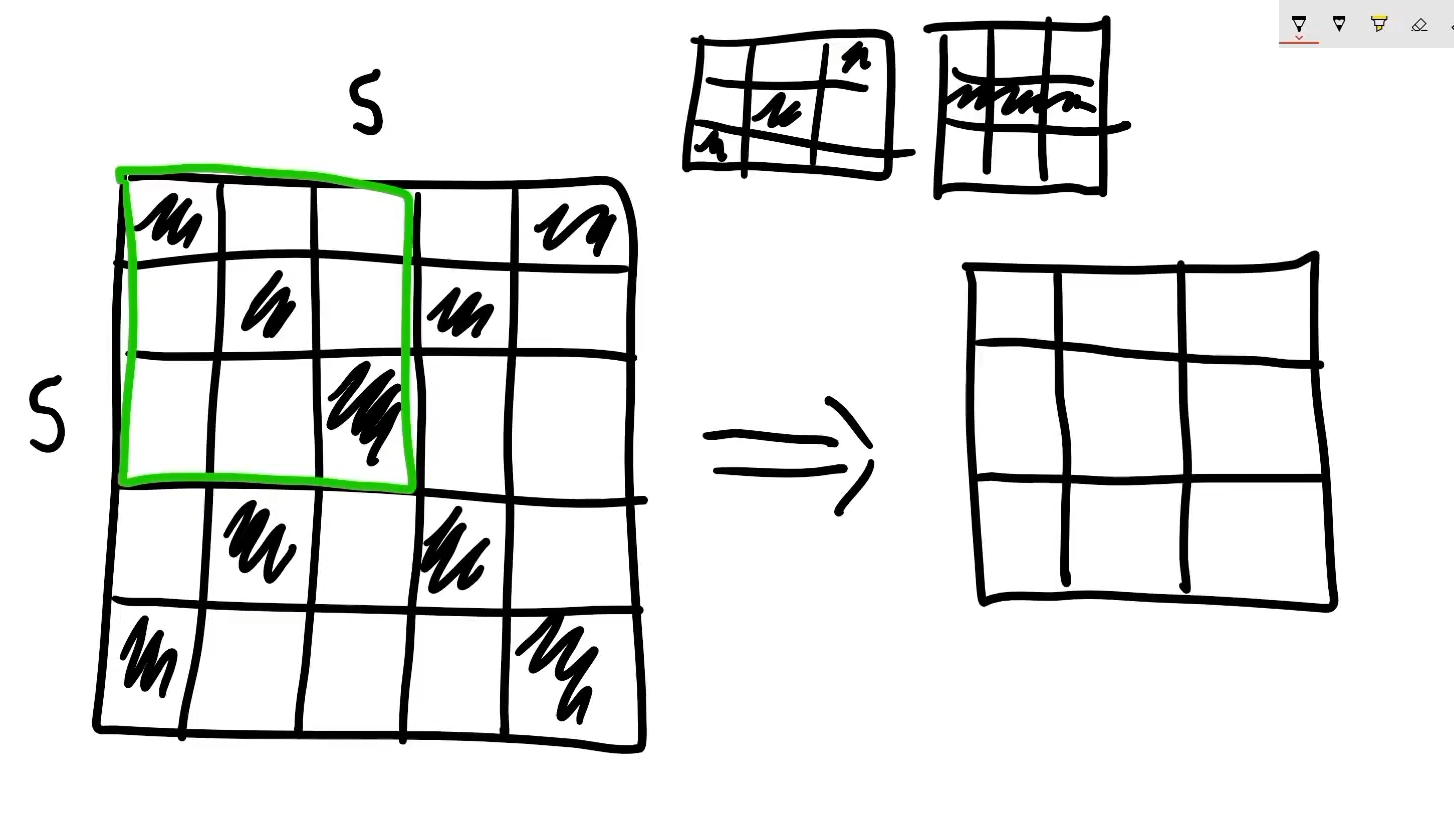

### Output af Convolutional Layer:
Outputtet kommer til at være en lille smule mindre end input laget, men det er jo fordi du har noget loss ude ved kanten. 

Når man sammenligner billedet med filteret, så tager man dot product mellem de to, da det jo kan ses som matricer. 

Da vi ser på to filtre, så kommer outputtet også til at være 2 feature maps. prikproduktet mellem en 0 og 1 kommer til at give 0, da de er orthohonale. 1 * 1 giver 1, da de er parallelle, så der hvor filter ligner op med original billedet, kommer outputtet til at være 1, og ellers 0 for alle andre.


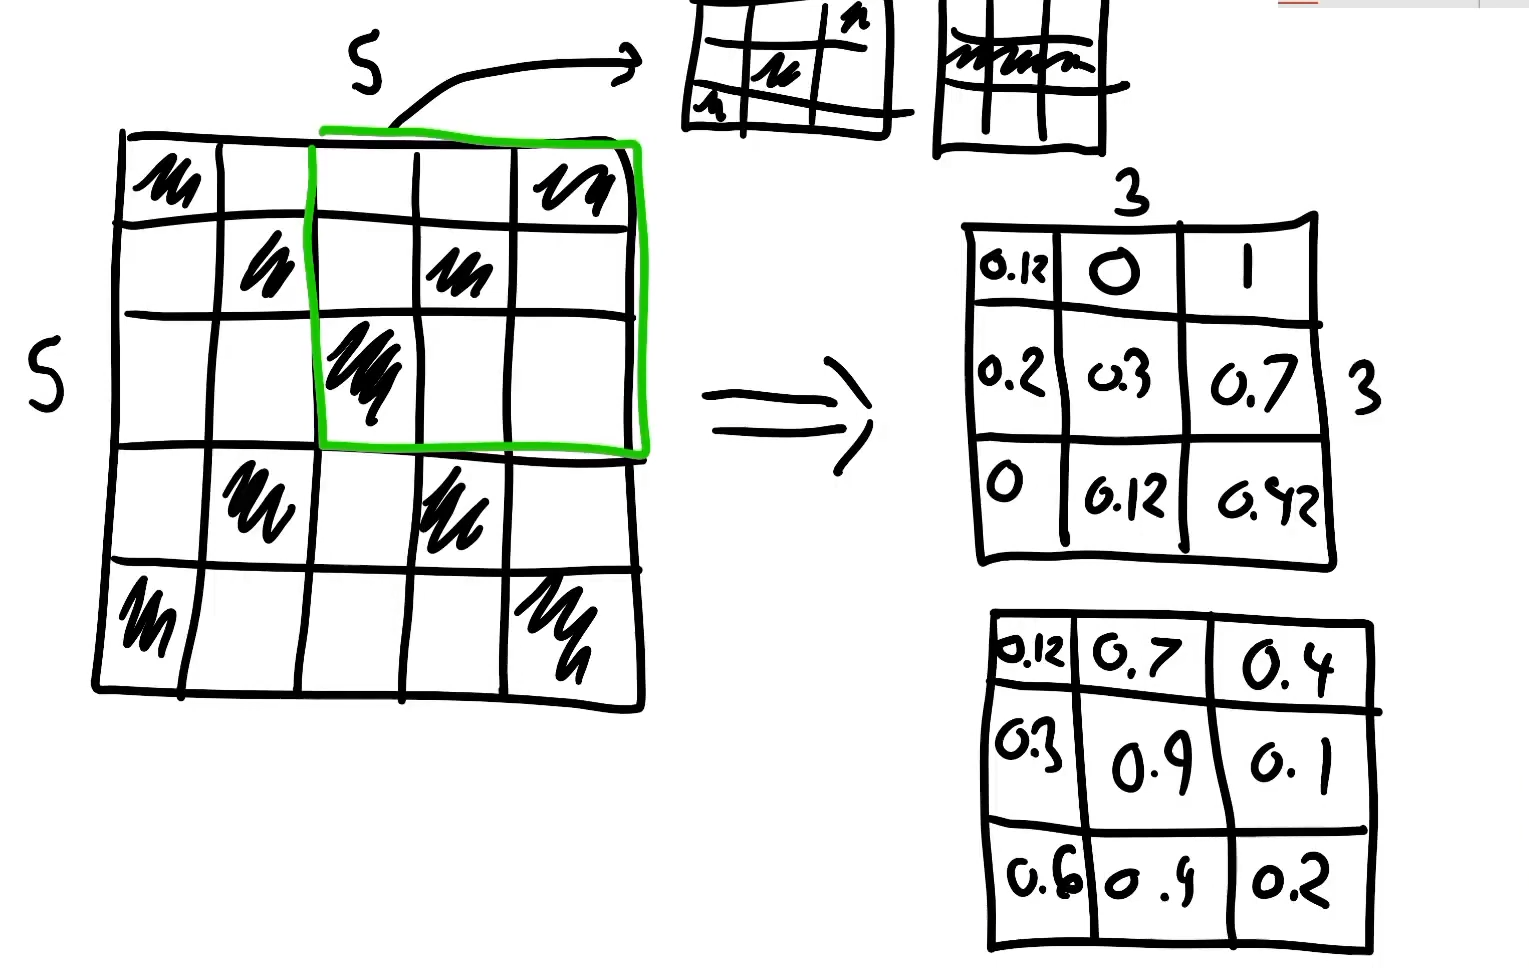

Når man gør dette for 64 filtre, så kommer det til at tage lang tid, og derfor kan man bruge pooling, som prøver at kombinere nogle af de foregående filtre?

### Padding

Man bruger det når outputtet skal være samme størrelse som originalbilledet. 

### Stride
Stride gør at du hopper mere end 1 pixel til siden hver gang. Det går hurtigere, men det er nok mere upræcist. 

### Pooling

- min 
- max
- average 

Typisk sampler man med 2x2 filtre oven i dit output feature map, så du egentlig laver et nyt map igen, som er endnu mindre end dit feature map. Her har man så fundet min, max eller average af de 2x2 pixels. Man laver også typisk pooling med stride af 2, så man kun ser samme pixels 1 gang. 

Max pooling bruges typisk til at se på den maksimale pressence i det field og area. 





# Creating A CNN:

1. Først skal vi skaffe et datasæt vi vil bruge. Eksemplet bruger CIFAR Image Dataset. Indeholder 60.000 billeder af størrelsen 32x32 med 10 forskellige objekter og der er 6000 af hver. 


In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

Load Images og split mellem train og test dataset.

In [ ]:
(train_images, train_labels),(test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images/255.0, test_images/255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



Sådan ser et billede ud:

In [ ]:
IMG_INDEX = 1
plt.imshow(train_images[IMG_INDEX],cmap=plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.show()

# CNN Architecture
Den mest normale arkitektur for CNN er at have stacks af Conv2D og MaxPooling2D lag, efterfulgt af få densly connected lag. 
Så man har altså et convolutional layer, og så et Maxpooling layer efterfølgende for at reducere kompleksiteten en smule, og sådan fortsætter man. Man har dog også en activation function i hvert convolutional layer, som gør outputtet mere brugbart. 

Herunder vises det:

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

In [ ]:
model.summary()

Vi får altså nu en model som har formen:
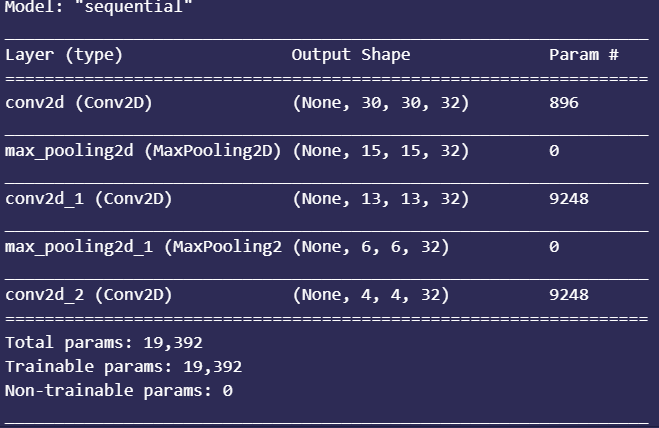

Hvilket ikke er slutningen på vores CNN. Det her er bare vores CNN base. Efter de her steps, så skal vores CNN Base inputtet is noget dense layer classifier. 

Herunder tilføjer vi vores dense layers.

In [ ]:
model.add(layers.Flatten()) #strækker modellen til at være én lang vektor.
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10)) #Fordi vi har 10 classes

In [ ]:
model.summary()

### Training the CNN
Vi har nu laves arkitekturen for vores CNN, og vi skal nu til at teste den. 
Vi bruger de anbefalede parametre fra tensorflow, og det her kommer til at tage laaang tid. 

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

### Evaluating the Model
Vi kan nu evaluere vores model med vores test_images

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

Vi får en accuracy på omkring 70% hvilket ikke er helt skidt når man "kun" har trænet på 60.000 billeder. Men hvordan kan man få en endnu bedre accuracy når man ikke har så mange billeder at gøre med?

### Working with small datasets
Man kan altså tage de samme billeder, og rotere dem random eller gøre andre ting ved dem, og så stadig få en god model. 


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_img = train_images[14]
img = image.img_to_array(test_img) #Konverterer til numpy array
img = img.reshape((1,) + img.shape) #Reshaper dit image

i = 0

for batch in datagen.flow(img, save_prefix='test', save_format='jpeg'):
    plt.figure(i)
    plot = plt.imshow(image.img_to_array(batch[0]))
    i+=1
    if i > 4:
        break
    
plt.show
                      

### Pretrained Models
Man kan også bruge pretrained models. Google og TensorFlow laver trained models, som er opensorce. Man kan bruge en pretrained model til ligesom at lave basen for en, og så bruger man kun fine tuning til ligesom at gøre ens classifier bedre. 

Det vil man gøre fordi den her model er blevet trænet på måske flere millioner billeder, så den er god til at generalisere ting på filterniveau med edges osv. Vi lægger så selv vores egen training data ind i modellen, men uden at modificere basen af modellen, vi skifter kun ud i de sidste lag i CNN, for at få det output vi gerne vil have. 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [ ]:
import tensorflow_datasets as tfds
print(tf.__version__)
tfds.disable_progress_bar()

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', 
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True, 
    as_supervised=True,
)

Hvis man kunne loade datasettet, så kunne man også se at ingen af dem havde samme dimension, hvilket normalt er et problem, da man definerer input size af billederne. 

Derfor skal alle billeder skaleres, så de bliver samme størrelse.

Det gør man med følgende code:

In [ ]:
IMG_SIZE = 160

def format_example(image,label):
    """
    Returns an image that is reshaped to IMG_SIZE
    """
    image = tf.cast(image, tf.float32)
    image = (image/127.5)-1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

Man kan nu bruge .map, til at omdanne alle trænings og test data med den nye funktion vi lige har lavet. 

In [ ]:
train = raw_tain.map(format_example)
validation = raw_validation(format_example)
test = raw_test.map(format_example)

In [ ]:
for image , label in train.take(2):
    plt.figure()
    plt.imshow()
    plt.title(get_label_name(label))



### Picked a Pretrained Model:
I eksemplet her bruger vi MobileNet V2, som er udviklet af Google. Modellen er trænet på over 1.4 mil. billeder af 1000 forskellige classes.
Vi vil gerne bruge denne model, men kun dens convolutional base. Så når vi loader modellen, skal skal man specificere hvad man ikke har lyst til at loade top laget, som er classification laget. Vi skal i stedet fortælle modellen hvilket input shape den skal forvente og bruge de "predetermined" vægte fra imagenet (Googles dataset).

In [56]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9420800/9406464 [==============================] - 1s 0us/step


In [ ]:
model.summary()